## Семинар 7: "Методы оптимизации"

ФИО:

In [291]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

import sys
thismodule = sys.modules[__name__]

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [263]:
class Optimizer:
    def __init__(self, f, df, init, max_iter):
        self.f = f
        self.df = df
        self.theta = np.array(init, dtype='float32')
        self.max_iter = max_iter
        self.step_n = 0
        
    def update(self, lr):
        self.step_n += 1
        self._update(lr)
        
class GD(Optimizer):
    def __init__(self, f, df, init=(1,1), max_iter=100):
        super().__init__(f, df, init, max_iter)
        
    def _update(self, lr):
        self.theta -= lr * self.df(self.theta)
        
class Momentum(Optimizer):
    def __init__(self, f, df, init=(1,1), max_iter=100, gamma=0.9):
        super().__init__(f, df, init, max_iter)
        self.gamma = gamma
        self.v = 0
        
    def _update(self, lr):
        self.v = self.v * self.gamma + lr * self.df(self.theta)
        self.theta -= self.v
        
class NAG(Optimizer):
    def __init__(self, f, df, init=(1,1), max_iter=100, gamma=0.9):
        super().__init__(f, df, init, max_iter)
        self.gamma = gamma
        self.v = 0
        
    def _update(self, lr):
        self.v = self.v * self.gamma + lr * self.df(self.theta - self.v * self.gamma)
        self.theta -= self.v
        
class Adagrad(Optimizer):
    def __init__(self, f, df, init=(1,1), max_iter=100, eps=1e-8):
        super().__init__(f, df, init, max_iter)
        self.eps = eps
        self.G = np.zeros_like(self.theta)
        
    def _update(self, lr): # lr is used as eta
        g = self.df(self.theta)
        self.G += g ** 2
        self.theta -= lr / np.sqrt(self.G + self.eps) * g
        
class Adadelta(Optimizer):
    def __init__(self, f, df, init=(1,1), max_iter=100, gamma=0.01, eps=1e-8):
        super().__init__(f, df, init, max_iter)
        self.gamma = gamma
        self.eps = eps
        self.EG = np.zeros_like(self.theta)
        self.EDelta = np.zeros_like(self.theta)
        
    def _update(self, lr):
        g = self.df(self.theta)
        self.EG = self.gamma * self.EG + (1 - self.gamma) * g ** 2
        dtheta = lr * np.sqrt((self.EDelta + self.eps) / (self.EG + self.eps)) * g
        self.EDelta = self.gamma * self.EDelta + (1 - self.gamma) * dtheta ** 2
        self.theta -= dtheta
        
class Adam(Optimizer):
    def __init__(self, f, df, init=(1,1), max_iter=100, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(f, df, init, max_iter)
        self.b1 = beta1
        self.b2 = beta2
        self.eps = eps
        self.m = np.zeros_like(self.theta)
        self.v = np.zeros_like(self.theta)
        
    def _update(self, lr):
        g = self.df(self.theta)
        self.m = self.b1 * self.m + (1 - self.b1) * g
        self.v = self.b2 * self.v + (1 - self.b2) * g ** 2
        m_cap = self.m / (1 - self.b1 ** self.step_n)
        v_cap = self.v / (1 - self.b2 ** self.step_n)
        self.theta -= lr * m_cap / (np.sqrt(v_cap) + self.eps)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [246]:
def plot_contour(f, xb=-2, xt=2, yb=-2, yt=2, delta=0.05):
    x = np.arange(xb, xt, delta)
    y = np.arange(yb, yt, delta)
    X, Y = np.meshgrid(x, y)
    
    Z = np.array([f(x) for x in np.c_[X.reshape(-1,1), Y.reshape(-1,1)]]).reshape(X.shape[0], X.shape[1])
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    
def plot_path(path, name):
    plt.plot(path[0], path[1], label=name)
    plt.scatter(path[0, -1:], path[1, -1:])

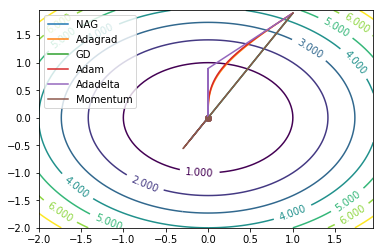

In [289]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])

optimizers = {
    'GD': 1e-1,
    'Momentum': 1e-2,
    'NAG': 1e-2,
    'Adagrad': 1e-1,
    'Adadelta': 1e0,
    'Adam': 1e-2,
}

plot_contour(f, xb=-2, xt=2, yb=-2, yt=2, delta=0.05)
path = np.zeros((2, 1000))
for opt_name in optimizers.keys():
    opt = getattr(thismodule, opt_name)(f, df, init=(1, 1.9))
    for i in range(path.shape[1]):
        path[0, i], path[1, i] = opt.theta
        opt.update(optimizers[opt_name])
    plot_path(path, opt_name)
    
plt.legend()

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

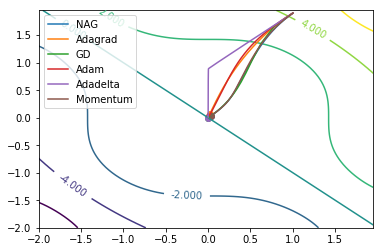

In [288]:
f = lambda X: np.sin(X[0])*X[0]**2+np.sin(X[1])*X[1]**2
df = lambda X: np.array([2*X[0]*np.sin(X[0]) + np.cos(X[0])*X[0]**2, 2*X[1]*np.sin(X[1]) + np.cos(X[1])*X[1]**2])

optimizers = {
    'GD': 1e-1,
    'Momentum': 1e-3,
    'NAG': 1e-3,
    'Adagrad': 1e-1,
    'Adadelta': 1e0,
    'Adam': 1e-2,
}

plot_contour(f, xb=-2, xt=2, yb=-2, yt=2, delta=0.05)
path = np.zeros((2, 1000))
for opt_name in optimizers.keys():
    opt = getattr(thismodule, opt_name)(f, df, init=(1, 1.9))
    for i in range(path.shape[1]):
        path[0, i], path[1, i] = opt.theta
        opt.update(optimizers[opt_name])
    plot_path(path, opt_name)
    
plt.legend()

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

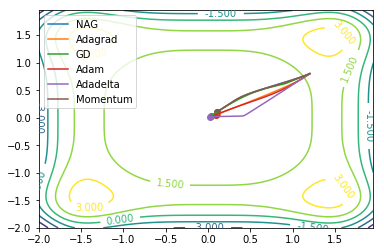

In [287]:
f = lambda X: np.sin(X[0]**2)*X[0]**2+np.sin(X[1]**2)*X[1]**2
df = lambda X: np.array([2*X[0]*np.sin(X[0]**2) + 2*np.cos(X[0]**2)*X[0]**3, \
                         2*X[1]*np.sin(X[1]**2) + 2*np.cos(X[1]**2)*X[1]**3])

optimizers = {
    'GD': 1e-1,
    'Momentum': 1e-3,
    'NAG': 1e-3,
    'Adagrad': 1e-1,
    'Adadelta': 1e0,
    'Adam': 1e-2,
}

plot_contour(f, xb=-2, xt=2, yb=-2, yt=2, delta=0.05)
path = np.zeros((2, 1000))
for opt_name in optimizers.keys():
    opt = getattr(thismodule, opt_name)(f, df, init=(1.2, 0.8))
    for i in range(path.shape[1]):
        path[0, i], path[1, i] = opt.theta
        opt.update(optimizers[opt_name])
    plot_path(path, opt_name)
    
plt.legend()

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, NAG и SGD (на MNIST). </i>

In [292]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('../data/mnist', train=False, download=False, transform=transform)
test_dataset = MNIST('../data/mnist', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [349]:
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 100),
                                           nn.ELU(),
                                           nn.Linear(100, 30),
                                           nn.ELU(),
                                           nn.Linear(30, 10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear_layers(x)
        return x

model = FcNet().cuda()

FcNet (
  (linear_layers): Sequential (
    (0): Linear (784 -> 100)
    (1): ELU (alpha=1.0)
    (2): Linear (100 -> 30)
    (3): ELU (alpha=1.0)
    (4): Linear (30 -> 10)
    (5): LogSoftmax ()
  )
)

In [354]:
def run(model, optimizer, epochs):
    loss_fn = torch.nn.NLLLoss()
    losses = []
    for epoch in range(epochs):
        model.train()
        for i, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            data = Variable(data)
            target = Variable(target, requires_grad=False)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            if i % 5 == 0:
                losses.append(loss.data[0])
#                 print('Epoch: {}. Loss: {}'.format(epoch, loss.data[0]))
    return losses

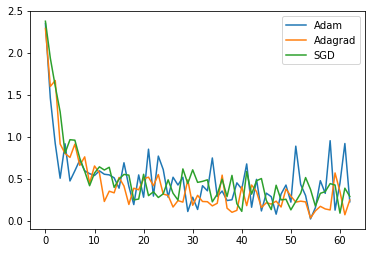

In [375]:
model = FcNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2) 
plt.plot(run(model, optimizer, 1), label='Adam')

model = FcNet().cuda()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01) 
plt.plot(run(model, optimizer, 1), label='Adagrad')

model = FcNet().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 
plt.plot(run(model, optimizer, 1), label='SGD')

plt.legend()

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, NAG и SGD. </i>

In [367]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 3, 3, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(28//2*28//2*3, 10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
model = ConvNet().cuda()

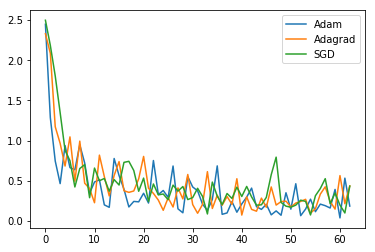

In [377]:
model = ConvNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2) 
plt.plot(run(model, optimizer, 1), label='Adam')

model = ConvNet().cuda()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.05) 
plt.plot(run(model, optimizer, 1), label='Adagrad')

model = ConvNet().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 
plt.plot(run(model, optimizer, 1), label='SGD')

plt.legend()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: